### Modeling

#### Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb

#### Data Preprocessing 

Load Data

In [3]:
def load_data(path='Data/', separate_country=False):
    # Load train and set
    X_train     = pd.read_csv(path+'X_train.csv', index_col='ID')
    Y_train     = pd.read_csv(path+'Y_train.csv', index_col='ID')
    X_test      = pd.read_csv(path+'X_test.csv', index_col='ID')
    Y_test      = pd.read_csv(path+'Y_test.csv', index_col='ID')

    # If separate country return separate dataset for each country
    if separate_country:
        # Join features and target for preprocessing
        train_df    = X_train.join(Y_train)
        test_df     = X_test.join(Y_test)

        # Split training data into DE and FR datasets
        train_fr    = train_df[train_df.COUNTRY=='FR']
        train_de    = train_df[train_df.COUNTRY=='DE']

        # Split test data into DE and FR datasets
        test_fr     = test_df[test_df.COUNTRY=='FR']
        test_de     = test_df[test_df.COUNTRY=='DE']

        X_train_fr  = train_fr.drop(columns=['TARGET','COUNTRY','DAY_ID'])
        X_train_de  = train_de.drop(columns=['TARGET','COUNTRY','DAY_ID'])
        Y_train_fr  = train_fr[['TARGET']]
        Y_train_de  = train_de[['TARGET']]
        
        X_test_fr  = test_fr.drop(columns=['TARGET','COUNTRY','DAY_ID'])
        X_test_de  = test_de.drop(columns=['TARGET','COUNTRY','DAY_ID'])
        Y_test_fr  = test_fr[['TARGET']]
        Y_test_de  = test_de[['TARGET']]
    
        return [X_train_fr, Y_train_fr, X_train_de, Y_train_de, X_test_fr, Y_test_fr, X_test_de, Y_test_de]
    
    # If NOT separate country then return full train and test data
    else:
        ohc                 = OneHotEncoder(drop='first')
        X_train['COUNTRY']  = ohc.fit_transform(X_train.COUNTRY.values.reshape(-1,1)).toarray()
        X_train.drop(columns=['DAY_ID'], inplace=True)
        
        X_test['COUNTRY']   = ohc.fit_transform(X_test.COUNTRY.values.reshape(-1,1)).toarray()
        X_test.drop(columns=['DAY_ID'], inplace=True)
        
        return [X_train, Y_train, X_test, Y_test]

In [4]:
X_train, Y_train, X_test, Y_test = load_data(separate_country=False)

Impute Missing Values

[Iterative Imputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer)  uses existing values as features to predict missing values using Bayesian Ridge regression. 

In [5]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

# Initialize the imputer
imputer = IterativeImputer(random_state=0)

# Fit and transform the data
X_imputed = imputer.fit_transform(X_train)

/Users/peterkeszthelyi/Library/Python/3.9/lib/python/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [6]:
X_train = pd.DataFrame(index=X_train.index, columns=X_train.columns, data=X_imputed)
X_test  = pd.DataFrame(index=X_test.index,  columns=X_test.columns,  data=imputer.transform(X_test)) 

#### Modeling

Helper functions

In [7]:
# Function to compute MSE and MAE
def evaluate_model(model, X_test, Y_test, print_only=False):
    y_preds = model.predict(X_test)
    mse = mean_squared_error(Y_test, y_preds)
    mae = mean_absolute_error(Y_test, y_preds)
    print(f"MSE {mse:.4f}")
    print(f"MAE {mae:.4f}")
    if not print_only: return [mse, mae]

Decision Tree

In [8]:
# Define parameter grid
param_grid_decision_tree = {'max_depth'         :   [None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30],
                            'min_samples_split' :   [5, 10, 50, 100],
                            'min_samples_leaf'  :   [10, 50, 100]
                            }

# Define GridSearchCV object
dt = GridSearchCV(
    DecisionTreeRegressor(random_state=1), 
    param_grid=param_grid_decision_tree, 
    cv=10, 
    n_jobs=-1, 
    scoring='neg_mean_squared_error'
)

# Fit GridSearch
dt.fit(X_train, Y_train)

# Print results
print(dt.best_params_)

mse_dt, mae_dt = evaluate_model(dt, X_test, Y_test)

{'max_depth': 2, 'min_samples_leaf': 50, 'min_samples_split': 5}
MSE 1.1421
MAE 0.8589


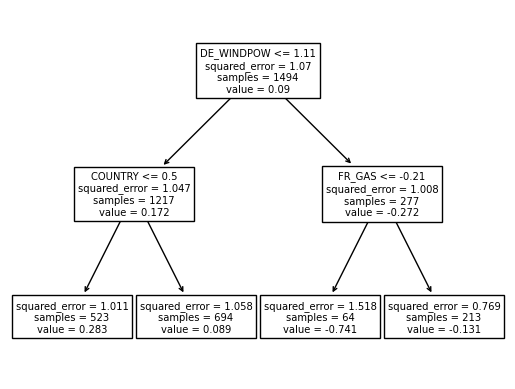

In [9]:
from sklearn.tree import plot_tree
plot_tree(dt.best_estimator_,feature_names=X_train.columns);

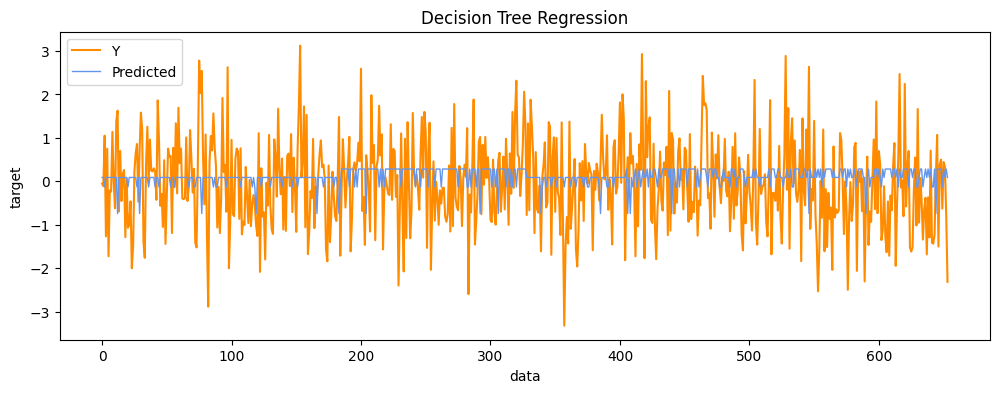

In [10]:
# Display the results
plt.figure(figsize=(12,4))
plt.plot(Y_test.values, c="darkorange", label="Y")
plt.plot(dt.predict(X_test), color="cornflowerblue", label="Predicted", linewidth=1)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

#### Bagging

In [11]:
# Define base estimator
base_estimator = DecisionTreeRegressor()

# Define parameter grid for BaggingRegressor
bagging_param_grid = {
    'estimator'         : [base_estimator],
    'n_estimators'      : [10, 50, 100],
    'max_samples'       : [0.5, 0.7, 1.0],
    'max_features'      : [0.5, 0.7, 1.0],
    'bootstrap'         : [True, False],
    'bootstrap_features': [True, False]
}
param_grid = {**bagging_param_grid}

# Initialize GridSearchCV
bgr_grid = GridSearchCV(
    estimator=BaggingRegressor(),
    param_grid=param_grid,
    cv=5,  # Cross-validation folds
    scoring='neg_mean_squared_error',  # Scoring metric
    n_jobs=-1
)

# Fit GridSearchCV to your data
bgr_grid.fit(X_train, Y_train.values.reshape(-1,1).ravel())

# Get the best parameters
best_params = bgr_grid.best_params_
print("Best hyperparameters:", best_params)

# Evaluate model
mse_bgr, mae_bgr = evaluate_model(bgr_grid,X_test, Y_test)

Best hyperparameters: {'bootstrap': True, 'bootstrap_features': True, 'estimator': DecisionTreeRegressor(), 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 50}
MSE 1.1578
MAE 0.8699


#### Random Forest

In [12]:
# Define parameter grid for Random Forest
param_grid = {
    'n_estimators':         [100, 300, 500],
    'max_depth':            [None, 5, 15],
    'min_samples_split':    [5, 10],
    'min_samples_leaf':     [4],
    'bootstrap':            [True]
}

# Initialize GridSearchCV
rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid,
    cv=5,  # Cross-validation folds
    scoring='neg_mean_squared_error',  # Scoring metric
    n_jobs=-1
)

# Fit GridSearchCV to your data
rf_grid.fit(X_train, Y_train.values.reshape(-1,1).ravel())

# Get the best parameters
best_params = rf_grid.best_params_
print("Best hyperparameters:", best_params)

# Evaluate model
mse_rf, mae_rf = evaluate_model(rf_grid, X_test, Y_test)

Best hyperparameters: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
MSE 1.1201
MAE 0.8504


#### AdaBoost

In [17]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0],
}

# Initialize GridSearchCV
adaboost_grid = GridSearchCV(
    estimator=AdaBoostRegressor(),
    param_grid=param_grid,
    cv=5,  # Cross-validation folds
    scoring='neg_mean_squared_error',  # Scoring metric
    n_jobs=-1
)

# Fit GridSearchCV to your data
adaboost_grid.fit(X_train, Y_train.values.reshape(-1,1).ravel())

# Get the best parameters
best_params = adaboost_grid.best_params_
print("Best hyperparameters:", best_params)

# Evaluate model
mse_adaboost, mae_adaboost = evaluate_model(adaboost_grid, X_test, Y_test)

Best hyperparameters: {'learning_rate': 0.01, 'n_estimators': 150}
MSE 1.1100
MAE 0.8488


#### Gradient Boosting Regressor (sklearn)

In [23]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 300],
    'learning_rate': [0.01, 0.05, 0.1],
}

# Initialize GridSearchCV
gradient_boosting_grid = GridSearchCV(
    estimator=GradientBoostingRegressor(),
    param_grid=param_grid,
    cv=5,  # Cross-validation folds
    scoring='neg_mean_squared_error',  # Scoring metric
    n_jobs=-1
)

# Fit GridSearchCV to your data
gradient_boosting_grid.fit(X_train, Y_train.values.reshape(-1,1).ravel())

# Get the best parameters
best_params = gradient_boosting_grid.best_params_
print("Best hyperparameters:", best_params)

# Evaluate model
mse_grad_boost, mae_grad_boost = evaluate_model(adaboost_grid, X_test, Y_test)

Best hyperparameters: {'learning_rate': 0.01, 'n_estimators': 50}
MSE 1.1100
MAE 0.8488


#### Extra Trees

In [24]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 300, 500],
    'max_depth': [None, 10, 20],
}

# Initialize GridSearchCV
extra_trees_grid = GridSearchCV(
    estimator=ExtraTreesRegressor(),
    param_grid=param_grid,
    cv=5,  # Cross-validation folds
    scoring='neg_mean_squared_error',  # Scoring metric
    n_jobs=-1
)

# Fit GridSearchCV to your data
extra_trees_grid.fit(X_train, Y_train.values.reshape(-1,1).ravel())

# Get the best parameters
best_params = extra_trees_grid.best_params_
print("Best hyperparameters:", best_params)

# Evaluate model
mse_extra_trees, mae_extra_trees = evaluate_model(extra_trees_grid,X_test,Y_test)


Best hyperparameters: {'max_depth': 10, 'n_estimators': 500}
MSE 1.1490
MAE 0.8639


#### XGBoost

In [25]:
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 5, 7],
}

# Initialize GridSearchCV
xgb_grid = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    cv=5,  # Cross-validation folds
    scoring='neg_mean_squared_error',  # Scoring metric
    n_jobs=-1
)

# Fit GridSearchCV to your data
xgb_grid.fit(X_train, Y_train)

# Get the best parameters
best_params = xgb_grid.best_params_
print("Best hyperparameters:", best_params)

# Evaluate model
predictions = xgb_grid.predict(X_test)
mse_xgb, mae_xgb = evaluate_model(xgb_grid,X_test, Y_test)

Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
MSE 1.0863
MAE 0.8378


### Evaluation

In [31]:
results = pd.DataFrame(
    data={'MSE':[mse_dt,mse_bgr,mse_rf,mse_adaboost,mse_grad_boost,mse_extra_trees,mse_xgb],
          'MAE':[mae_dt,mae_bgr,mae_rf,mae_adaboost,mae_grad_boost,mae_extra_trees,mae_xgb]},
    index=['Decision Tree','Bagging','RandomForest','AdaBoost','GradBoost (sklearn)','ExtraTrees','XGBoost']
)

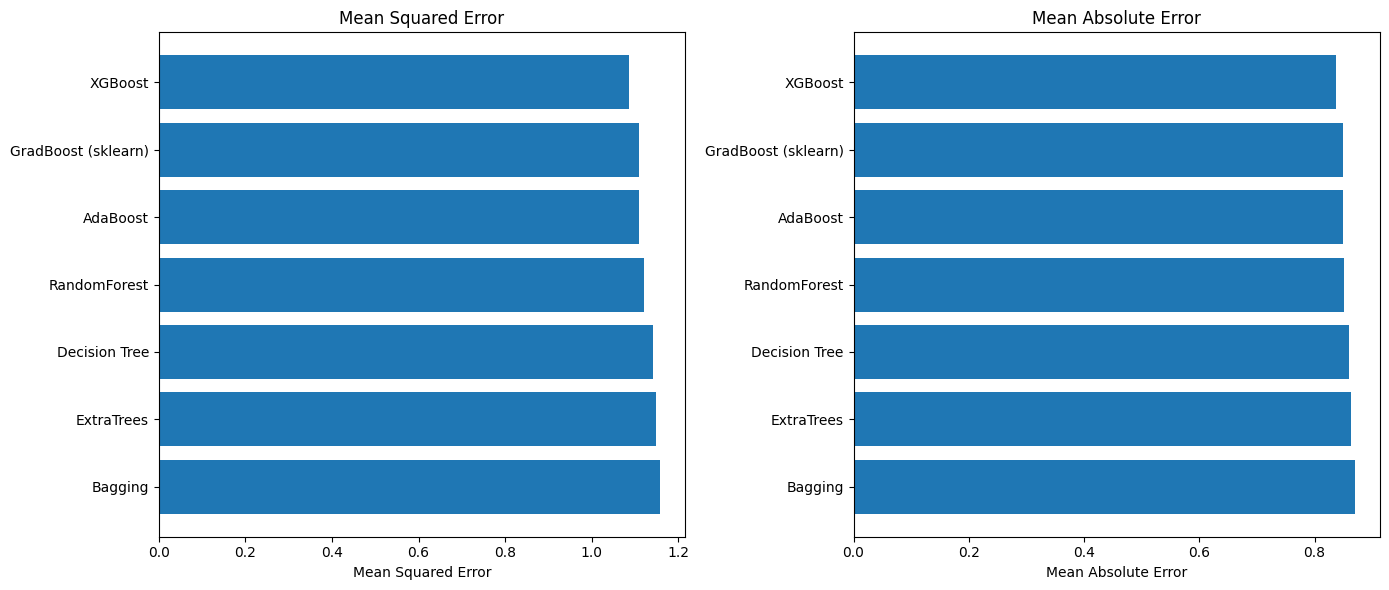

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# Plot MSE values
axes[0].barh(results['MSE'].sort_values(ascending=False).index, results['MSE'].sort_values(ascending=False))
axes[0].set_xlabel('Mean Squared Error')
axes[0].set_title('Mean Squared Error')
# Plot MAE values
axes[1].barh(results['MAE'].sort_values(ascending=False).index, results['MAE'].sort_values(ascending=False))
axes[1].set_xlabel('Mean Absolute Error')
axes[1].set_title('Mean Absolute Error')
plt.tight_layout()
plt.show()
